# Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from keras.applications.imagenet_utils import decode_predictions 
from sklearn import preprocessing
from sklearn import metrics
import glob
import cv2
import os
import gc
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset

In [2]:
train_data = []
train_labels = [] 

In [3]:
#load training data
for directory_path in glob.glob("dataset/training/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        img = cv2.resize(img, (508, 274))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_data.append(img)
        train_labels.append(label)
        

In [4]:
len(train_labels)

4617

In [5]:
#convert into numby array
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [6]:
validation_data = []
validation_labels = [] 

In [7]:
#load validation data
for directory_path in glob.glob("dataset/validation/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (508, 274))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        validation_data.append(img)
        validation_labels.append(label)

In [8]:
#convert into numby array
validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels)

# Transform the labels

In [9]:
#create a label encoder
le = preprocessing.LabelEncoder()

In [10]:
#transform validation label into 0 or 1
le.fit(validation_labels)
y_test = le.transform(validation_labels)

In [11]:
#transform training label into 0 or 1
le.fit(train_labels)
y_train = le.transform(train_labels)

In [12]:
train_data.shape

(4617, 274, 508, 3)

In [13]:
#reshape the training data array
train_data = train_data.reshape(train_data.shape[0],train_data.shape[2],train_data.shape[1],train_data.shape[3])

In [14]:
#reshape the validation data array
validation_data = validation_data.reshape(validation_data.shape[0],validation_data.shape[2],validation_data.shape[1],validation_data.shape[3])

# Feature extraction

In [15]:
#create RestNet50 model
resnet_model = tf.keras.applications.ResNet50(include_top=False,

                   input_shape=(508, 274,3),

                   pooling='min',

                   weights='imagenet')

for each_layer in resnet_model.layers:

        each_layer.trainable=False
        


In [16]:
print(resnet_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 508, 274, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 514, 280, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 254, 137, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 127, 69, 64)  16448       ['conv2_block2_out[0][0]']       
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 127, 69, 64)  256        ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 127, 69, 64)  0          ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 127, 69, 64)  36928       ['conv2_block3_1_relu[0][0]']    
          

                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 35, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 64, 35, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 64, 35, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 64, 35, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_add (Add)         (None, 32, 18, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 32, 18, 1024  0           ['conv4_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 32, 18, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 32, 18, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block4_add (Add)         (None, 32, 18, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 32, 18, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 32, 18, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 32, 18, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

 conv5_block1_0_bn (BatchNormal  (None, 16, 9, 2048)  8192       ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 16, 9, 2048)  8192       ['conv5_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 16, 9, 2048)  0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 16, 9, 2048)  0           ['conv5_block1_add[0][0]']       
          

In [17]:
#extract the training features
X_train = resnet_model.predict(train_data)

145/145 [==============================] - 1731s 12s/step


In [18]:
#extract the validation features
X_test = resnet_model.predict(validation_data)

19/19 [==============================] - 251s 13s/step


In [19]:
X_train.shape

(4617, 16, 9, 2048)

In [20]:
X_test.shape

(577, 16, 9, 2048)

In [21]:
#reshape training extracted feature array
X_train = np.reshape(X_train, (4617, 16*9*2048))

In [22]:
#reshape validation extracted feature array
X_test = np.reshape(X_test, (577, 16*9*2048))

# Classification

In [23]:
#create SVM model
svm_model = svm.SVC(C=1, gamma=1, kernel='linear')

In [24]:
#fit training data into SVM model
svm_model.fit(X_train,y_train)

SVC(C=1, gamma=1, kernel='linear')

# Model evaluation

In [25]:
#predit validation data
test_prediction = svm_model.predict(X_test)

In [26]:
#get accuracy score for validation data
print("Accuracy:",metrics.accuracy_score(y_test, test_prediction)*100)

Accuracy: 82.66897746967071


In [27]:
#get precision and recall
print("Precision:",metrics.precision_score(y_test, test_prediction))

print("Recall:",metrics.recall_score(y_test, test_prediction))

Precision: 0.8590163934426229
Recall: 0.8213166144200627


In [28]:
#get classification report
print(classification_report(y_test, test_prediction))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       258
           1       0.86      0.82      0.84       319

    accuracy                           0.83       577
   macro avg       0.82      0.83      0.83       577
weighted avg       0.83      0.83      0.83       577



In [29]:
#get confution matrix
cm = confusion_matrix(y_test, test_prediction, labels = svm_model.classes_)

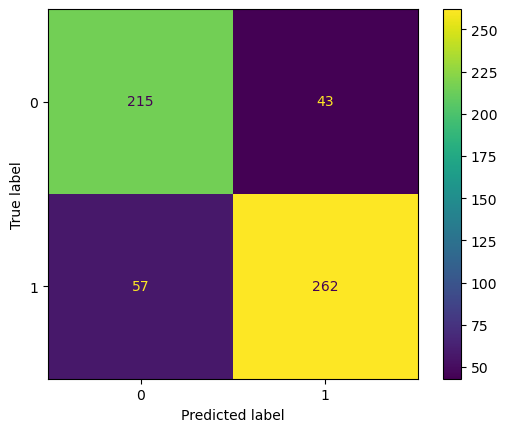

In [31]:
#plot confution matrix
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm_model.classes_)  
cmd.plot()
plt.show()